# Python：爬取东方财富股吧评论进行情感分

- 梁海, 2020, [Python：爬取东方财富股吧评论进行情感分析](https://www.lianxh.cn/details/440.html), 连享会 No.440.

In [12]:
# 导入必要的库
# pip install akshare
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

# 设置起始时间和结束时间
start_date = '1991-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  # 设置为当前日期

# 获取上证指数的历史数据
sz_index = ak.stock_zh_index_daily(symbol="sh000001")  # 上证指数代码为 "sh000001"

# 重命名列名以便后续处理
sz_index.rename(columns={'date': 'day', 'close': 'close'}, inplace=True)

# 筛选指定起止时间的数据
sz_index['day'] = pd.to_datetime(sz_index['day'])  # 确保日期列为 datetime 类型
sz_index = sz_index[(sz_index['day'] >= pd.to_datetime(start_date)) & (sz_index['day'] <= pd.to_datetime(end_date))]
print(sz_index.head())  # 显示前几行数据
print(sz_index.tail())  # 显示后几行数据


          day    open    high     low   close  volume
9  1991-01-02  127.61  128.84  127.61  128.84    9100
10 1991-01-03  128.84  130.14  128.84  130.14   14100
11 1991-01-04  131.27  131.44  130.14  131.44   42000
12 1991-01-07  131.99  132.06  131.45  132.06   21700
13 1991-01-08  132.62  132.68  132.06  132.68  292600
            day      open      high       low     close       volume
8385 2025-04-24  3295.149  3313.509  3286.236  3297.288  39284474900
8386 2025-04-25  3300.392  3305.262  3288.755  3295.060  41104319200
8387 2025-04-28  3292.056  3296.932  3279.877  3288.415  41066586300
8388 2025-04-29  3281.445  3294.982  3277.627  3286.655  38896167200
8389 2025-04-30  3284.081  3292.200  3277.550  3279.031  43579433500


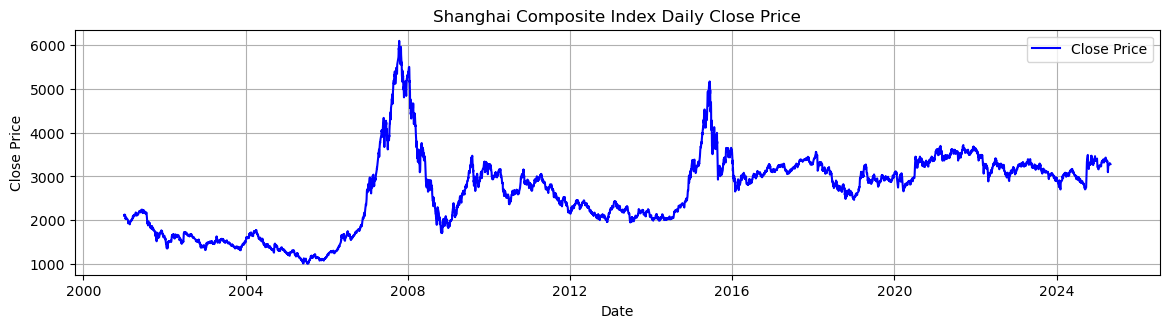

In [ ]:
# 绘制收盘价走势图
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(sz_index['day'], sz_index['close'], label='Close Price', color='blue')
plt.title('Shanghai Composite Index Daily Close Price') 
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()


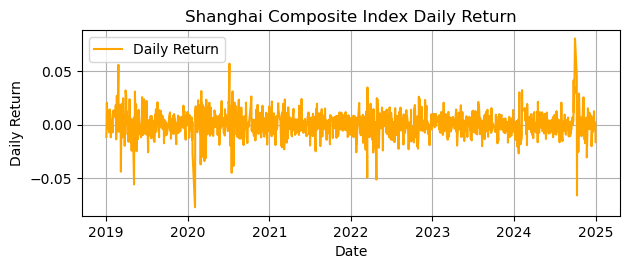

In [ ]:
# 计算日收益率
sz_index['daily_return'] = sz_index['close'].pct_change()  # 计算日收益率

# 绘制日收益率走势图
#-- 控制绘图的时间范围
#start_plot_date = '1991-01-01'
start_plot_date = '2019-01-01'
end_plot_date   = '2025-01-01'
sz_index_plot = sz_index[(sz_index['day'] >= pd.to_datetime(start_plot_date)) & 
                         (sz_index['day'] <= pd.to_datetime(end_plot_date))]
plt.subplot(2, 1, 2)
plt.plot(sz_index_plot['day'], 
         sz_index_plot['daily_return'], 
         label='Daily Return', 
         color='orange')
plt.title('Shanghai Composite Index Daily Return')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid()
plt.tight_layout()  # 调整子图间距


## 周收益率和月收益率
- 周收益率：`(本周收盘价 - 上周收盘价) / 上周收盘价`
- 月收益率：`(本月收盘价 - 上月收盘价) / 上月收盘价`

In [59]:
# 计算每周的收益率
sz_index['week'] = sz_index['day'].dt.isocalendar().week  # 提取周数
sz_index['year_week'] = sz_index['day'].dt.year.astype(str) \
                        + '-w' \
                        + sz_index['week'].astype(str).str.zfill(2)  # 组合年份和周数，周数补零

# 计算每周的收益率
weekly_return = sz_index.groupby('year_week')['close'].apply(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0])
weekly_return = weekly_return.reset_index()  # 重置索引
weekly_return.columns = ['Year_Week', 'Weekly_Return']  # 重命名列

# 打印结果
print(weekly_return.sort_values(by='Year_Week').tail(10))  # 按时间顺序显示最后20周的收益率


     Year_Week  Weekly_Return
1729  2025-w09      -0.015455
1730  2025-w10       0.016769
1731  2025-w11       0.015863
1732  2025-w12      -0.017891
1733  2025-w13      -0.005555
1734  2025-w14       0.001877
1735  2025-w15       0.045744
1736  2025-w16       0.004267
1737  2025-w17       0.001102
1738  2025-w18      -0.002854


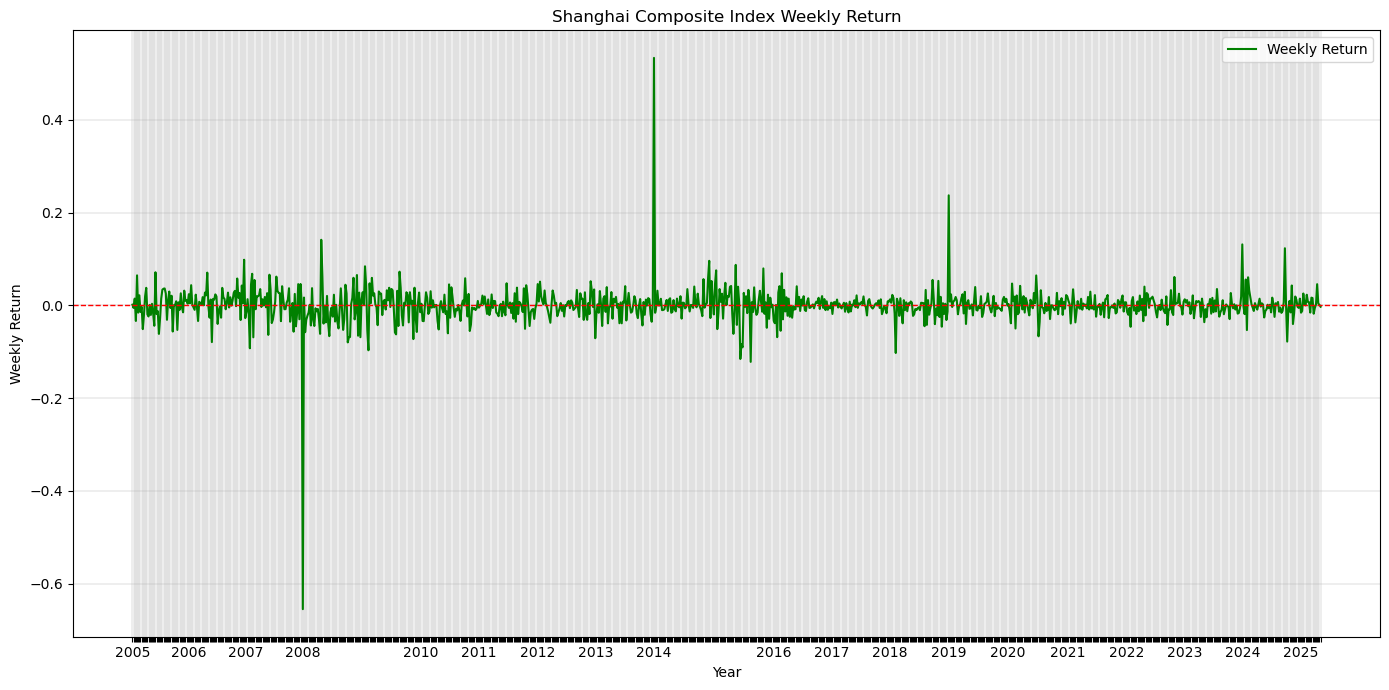

In [60]:
# 设置起始时间和结束时间
start_week = '2005-w01'
end_week = '2028-w16'

# 筛选指定时间范围内的数据
filtered_weekly_return = weekly_return[(weekly_return['Year_Week'] >= start_week) & 
                                       (weekly_return['Year_Week'] <= end_week)]

# 绘制每周收益率走势图
plt.figure(figsize=(14, 7))
plt.plot(filtered_weekly_return['Year_Week'], filtered_weekly_return['Weekly_Return'], label='Weekly Return', color='green')
plt.title('Shanghai Composite Index Weekly Return')
plt.xlabel('Year')
plt.ylabel('Weekly Return')

# 修改 x 轴标签，仅显示年份
year_labels = [label.split('-')[0] if label.endswith('-w01') else '' for label in filtered_weekly_return['Year_Week']]
plt.xticks(ticks=range(len(year_labels)), labels=year_labels, rotation=0)

# 添加 y=0 的水平线
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# 设置 grid，仅显示主要的 grid
plt.grid(visible=True, which='major', linestyle='-', linewidth=0.3)

plt.legend()
plt.tight_layout()  # 调整子图间距
plt.show()  # 显示图形


#### 核心代码解读：

- `sz_index['day'].dt.isocalendar().week`：获取日期的周数。具体而言，`dt.isocalendar()` 返回一个 DataFrame，其中包含 ISO 日历的年、周和星期几。我们只需要周数，因此使用 `.week` 来提取它。类似的，可以使用 `.dt.isocalendar().month` 来获取月份；用 `.dt.isocalendar().year` 来获取年份。
    - `sz_index['day'].dt.isocalendar().year`：获取日期的年份。类似地，使用 `.year` 来提取年份。
- `weekly_return = sz_index.groupby('year_week')['close'].apply(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0])`：对每个周进行分组，计算该周的收益率。具体而言，`groupby('year_week')` 将数据按年和周进行分组，然后使用 `apply()` 函数对每个组应用一个 lambda 函数。这个 lambda 函数计算该组的最后一个收盘价和第一个收盘价之间的收益率。
    - `apply()` 函数的用法：`apply()` 函数可以对 DataFrame 或 Series 的每一行或每一列应用一个函数。它可以用于数据转换、聚合和其他操作。在这里，我们使用 `apply()` 函数来计算每个组的收益率。`apply()` 函数的语法格式为：
        ```python
        DataFrame.apply(func, axis=0, raw=False, result_type=None, args=(), **kwds)
        ```
        - `func`：要应用的函数，可以是 Python 内置函数或自定义函数。
        - `axis`：指定应用函数的轴，0 表示按列应用，1 表示按行应用。默认值为 0。
        - `raw`：如果为 True，则传递原始数据而不是 Series 对象。默认值为 False。
    - `lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0]`：这是一个匿名函数，用于计算每个组的收益率。`x` 是传递给 lambda 函数的参数，表示当前组的数据。`x.iloc[-1]` 表示该组的最后一个收盘价，`x.iloc[0]` 表示该组的第一个收盘价。通过计算这两个值之间的差值并除以第一个收盘价，我们得到了该组的收益率。

In [66]:
# 列出周收益率绝对值大于 0.2 的周
high_weekly_return = weekly_return[weekly_return['Weekly_Return'].abs() > 0.2]

# 按收益率排序
high_weekly_return = high_weekly_return.sort_values(by='Weekly_Return', ascending=False)  
print('\n' + '---'*5 + 'high weekly return' + '---'*5)
print(high_weekly_return)  # 打印结果

# 按时间排序
high_weekly_return = high_weekly_return.sort_values(by='Year_Week')  # 按时间排序
print('\n' + '---'*5 + 'sorted by Year_Week' + '---'*5)
print(high_weekly_return)  # 打印结果


---------------high weekly return---------------
     Year_Week  Weekly_Return
72    1992-w21       1.343377
0     1991-w01       1.272198
259   1996-w01       0.704906
99    1992-w48       0.553815
1159  2014-w01       0.533468
186   1994-w31       0.532717
226   1995-w20       0.470363
118   1993-w14       0.311382
309   1997-w01       0.298735
1415  2019-w01       0.237227
507   2001-w01      -0.217497
854   2008-w01      -0.654681

---------------sorted by Year_Week---------------
     Year_Week  Weekly_Return
0     1991-w01       1.272198
72    1992-w21       1.343377
99    1992-w48       0.553815
118   1993-w14       0.311382
186   1994-w31       0.532717
226   1995-w20       0.470363
259   1996-w01       0.704906
309   1997-w01       0.298735
507   2001-w01      -0.217497
854   2008-w01      -0.654681
1159  2014-w01       0.533468
1415  2019-w01       0.237227


## 年化收益率和标准差

In [57]:

# 各个年度的收益率和标准差
sz_index['year'] = sz_index['day'].dt.year  # 提取年份
annual_stats = sz_index.groupby('year').agg({'daily_return': ['mean', 'std']}).reset_index()

# 重命名列名
annual_stats.columns = ['Year', 'Mean Daily Return', 'Std Daily Return']
# 将收益率和标准差转换为百分比，并计算年化收益率和年化标准差
annual_stats['Mean Daily Return'] = annual_stats['Mean Daily Return'] * 100  # 转换为百分比
annual_stats['Std Daily Return'] = annual_stats['Std Daily Return'] * 100  # 转换为百分比
annual_stats['Annualized Return'] = annual_stats['Mean Daily Return'] * 252 / 100  # 年化收益率
annual_stats['Annualized Std'] = annual_stats['Std Daily Return'] * (252 ** 0.5) / 100  # 年化标准差
# 打印单数年份的收益率和标准差，小数点后保留三位，四列在同一行呈现
print(annual_stats[annual_stats['Year'] % 2 == 1][['Year', 'Mean Daily Return', 'Std Daily Return', 'Annualized Return', 'Annualized Std']].round(3).to_string(index=False))


 Year  Mean Daily Return  Std Daily Return  Annualized Return  Annualized Std
 1991              0.326             0.662              0.821           0.105
 1993              0.096             3.781              0.243           0.600
 1995             -0.016             3.103             -0.041           0.493
 1997              0.133             2.194              0.335           0.348
 1999              0.089             1.773              0.224           0.281
 2001             -0.087             1.387             -0.218           0.220
 2003              0.047             1.143              0.118           0.181
 2005             -0.027             1.378             -0.067           0.219
 2007              0.305             2.216              0.768           0.352
 2009              0.259             1.901              0.653           0.302
 2011             -0.093             1.156             -0.235           0.183
 2013             -0.023             1.159             -0.057   

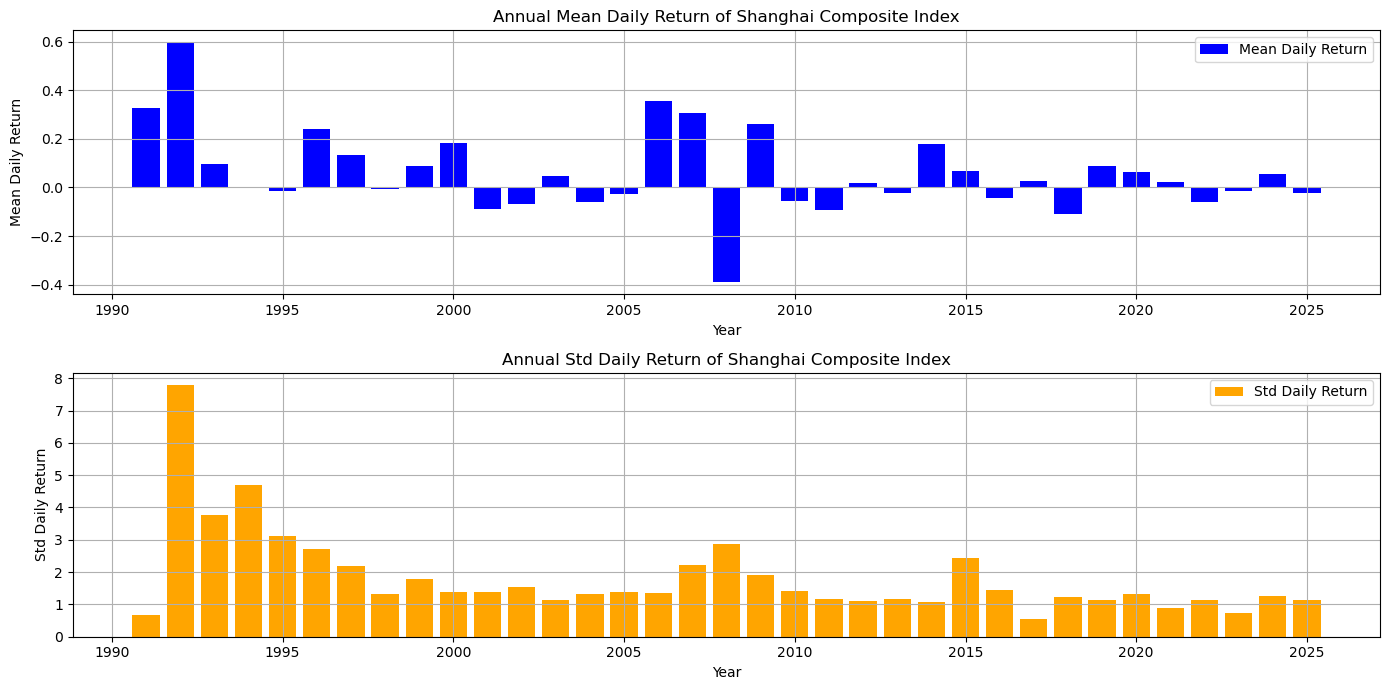

In [58]:
# 图示各个年度收益率和标准差
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.bar(annual_stats['Year'], annual_stats['Mean Daily Return'], color='blue', label='Mean Daily Return')
plt.title('Annual Mean Daily Return of Shanghai Composite Index')
plt.xlabel('Year')
plt.ylabel('Mean Daily Return')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.bar(annual_stats['Year'], annual_stats['Std Daily Return'], color='orange', label='Std Daily Return')
plt.title('Annual Std Daily Return of Shanghai Composite Index')
plt.xlabel('Year')
plt.ylabel('Std Daily Return')
plt.legend()
plt.grid()
plt.tight_layout()  # 调整子图间距
plt.show()  # 显示图形




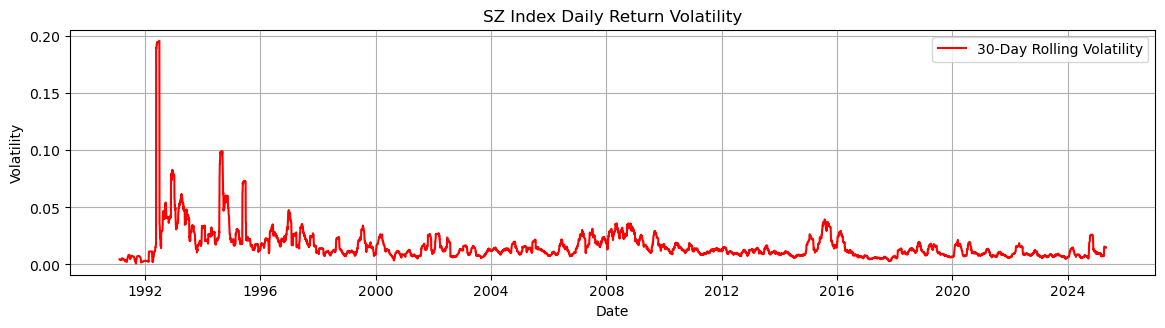

In [17]:

# 图示波动率
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(sz_index['day'], 
         sz_index['daily_return'].rolling(window=30).std(), 
         label='30-Day Rolling Volatility', 
         color='red')
plt.title('SZ Index Daily Return Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()  # 显示图形


<Figure size 400x300 with 0 Axes>

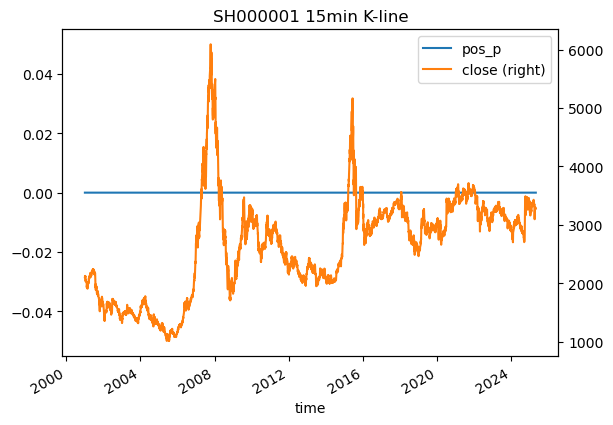

In [10]:

# 将日期列转换为 datetime 类型
sz_index['day'] = pd.to_datetime(sz_index['day'])

# 将收盘价列转换为浮点数类型
sz_index['close'] = sz_index['close'].astype('float')

# 创建一个示例 DataFrame，用于合并
data = pd.DataFrame({'time': sz_index['day'], 'pos_p': [0] * len(sz_index)})

# 合并两个 DataFrame，基于时间列进行内连接
data = data.merge(sz_index, left_on='time', right_on='day', how='inner')

# 绘制图表
plt.figure(figsize=(4, 3))  # 设置图表大小
data.index = data['time']  # 将时间列设置为索引
data[['pos_p', 'close']].plot(secondary_y=['close'])  # 绘制双 Y 轴图表
plt.title('SH000001 15min K-line')  # 设置图表标题
plt.show()  # 显示图表

sysuse "auto.dta", clear
scatter mpg weight